In [3]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [4]:
import zipfile
import os

with zipfile.ZipFile("archive (1).zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [5]:
!ls /content


'archive (1).zip'   sample_data   Testing   Training


In [6]:
import os

base_dir = "/content"

train_dir = os.path.join(base_dir, "Training")
test_dir  = os.path.join(base_dir, "Testing")

print("Training classes:", os.listdir(train_dir))
print("Testing classes:", os.listdir(test_dir))

Training classes: ['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'no_tumor']
Testing classes: ['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'no_tumor']


In [16]:
IMG_SIZE = (224, 224)
BATCH = 16
SEED = 42

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",   # multi-class (4 classes)
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)

# ✅ grab class names here before caching
class_names = train_ds_raw.class_names
print("Classes:", class_names)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)


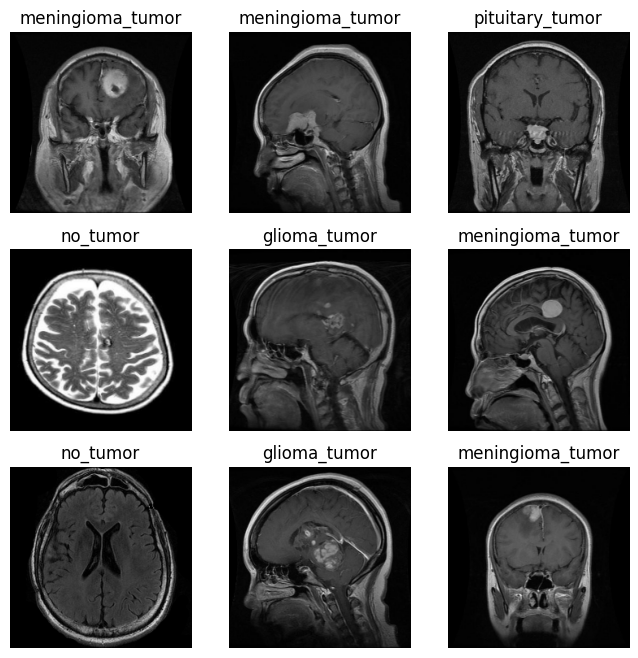

In [20]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")


In [21]:
from tensorflow.keras import layers, models, applications

base_model = applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False  # freeze base model for transfer learning

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - accuracy: 0.2857 - loss: 1.3906 - val_accuracy: 0.3049 - val_loss: 1.3444
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2978 - loss: 1.3702 - val_accuracy: 0.2631 - val_loss: 1.3677
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2605 - loss: 1.3861 - val_accuracy: 0.2979 - val_loss: 1.3486
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2765 - loss: 1.3742 - val_accuracy: 0.2631 - val_loss: 1.3580
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2978 - loss: 1.3741 - val_accuracy: 0.2631 - val_loss: 1.3671
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2875 - loss: 1.3732 - val_accuracy: 0.2979 - val_loss: 1.3480
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2904 - loss: 1.3746 - val_accuracy: 0.2979 - val_loss: 1.3495
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2882 - loss: 1.3662 - val_ac

In [23]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - accuracy: 0.2481 - loss: 1.5068
Test Accuracy: 0.25380709767341614


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3060 - loss: 1.3730 - val_accuracy: 0.2631 - val_loss: 1.3820
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2988 - loss: 1.3684 - val_accuracy: 0.2979 - val_loss: 1.3554
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2631 - loss: 1.3761 - val_accuracy: 0.2631 - val_loss: 1.3864
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2809 - loss: 1.3711 - val_accuracy: 0.2631 - val_loss: 1.3763
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3008 - loss: 1.3641 - val_accuracy: 0.2631 - val_loss: 1.3571


In [27]:
base_model.trainable = True  # unfreeze all layers

# Optionally, freeze only the very early layers (low-level features)
for layer in base_model.layers[:100]:   # keep first 100 layers frozen
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),   # smaller LR
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 89s 293ms/step - accuracy: 0.2983 - loss: 1.4055 - val_accuracy: 0.2979 - val_loss: 1.4579
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4929 - loss: 1.1462 - val_accuracy: 0.3746 - val_loss: 1.3256
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5414 - loss: 1.0529 - val_accuracy: 0.5070 - val_loss: 1.2341
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5716 - loss: 0.9851 - val_accuracy: 0.5575 - val_loss: 1.0851
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5605 - loss: 0.9651 - val_accuracy: 0.5767 - val_loss: 0.9854
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6050 - loss: 0.9236 - val_accuracy: 0.6063 - val_loss: 0.9278
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5862 - loss: 0.9136 - val_accuracy: 0.5819 - val_loss: 0.9494
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6024 - loss: 0.8959 - val_ac

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),   # smaller LR
              loss="categorical_crossentropy",
              metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
import os
for c in class_names:
    print(c, "Training:", len(os.listdir(os.path.join(train_dir, c))),
              "Testing:", len(os.listdir(os.path.join(test_dir, c))))


glioma_tumor Training: 826 Testing: 100
meningioma_tumor Training: 822 Testing: 115
no_tumor Training: 395 Testing: 105
pituitary_tumor Training: 827 Testing: 74


In [39]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# class indices in order of class_names
class_labels = np.array(class_names)

# count samples per class
train_counts = [len(os.listdir(os.path.join(train_dir, c))) for c in class_names]

# compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=np.concatenate([
        np.full(count, i) for i, count in enumerate(train_counts)
    ])
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.8686440677966102), 1: np.float64(0.8728710462287105), 2: np.float64(1.8164556962025316), 3: np.float64(0.8675937122128174)}


In [40]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.3565 - loss: 1.3209 - val_accuracy: 0.5627 - val_loss: 1.1187
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.4836 - loss: 1.1416 - val_accuracy: 0.5801 - val_loss: 1.0786
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.5089 - loss: 1.0832 - val_accuracy: 0.6098 - val_loss: 1.0200
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.5481 - loss: 1.0457 - val_accuracy: 0.5557 - val_loss: 1.0317
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5353 - loss: 1.0098 - val_accuracy: 0.6220 - val_loss: 0.9292
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5486 - loss: 1.0120 - val_accuracy: 0.6272 - val_loss: 0.9193
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5611 - loss: 0.9988 - val_accuracy: 0.6638 - val_loss: 0.8392
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5695 - loss: 0.9602 

In [41]:
from tensorflow.keras import layers, models, applications

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

base_model = applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # first train with frozen weights

model = models.Sequential([
    data_augmentation,                               # <-- added here
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.5807 - loss: 0.9219 - val_accuracy: 0.6463 - val_loss: 0.8395
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5692 - loss: 0.9200 - val_accuracy: 0.6585 - val_loss: 0.8358
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.6099 - loss: 0.8921 - val_accuracy: 0.6777 - val_loss: 0.8124
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5771 - loss: 0.9007 - val_accuracy: 0.6707 - val_loss: 0.8258
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5812 - loss: 0.9179 - val_accuracy: 0.6394 - val_loss: 0.8325
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.5978 - loss: 0.8852 - val_accuracy: 0.6376 - val_loss: 0.8475


In [64]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ==========================
# 1. Data Augmentation
# ==========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    "dataset",  # Corrected path
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    "dataset", # Corrected path
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# ==========================
# 2. Compute Class Weights
# ==========================
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ==========================
# 3. Transfer Learning (ResNet50)
# ==========================
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)   # Regularization
predictions = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model first
for layer in base_model.layers:
    layer.trainable = False

# Compile
model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# ==========================
# 4. Training
# ==========================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

# Fine-tuning: unfreeze some layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)

Found 2612 images belonging to 2 classes.
Found 652 images belonging to 2 classes.
Class Weights: {0: np.float64(4.132911392405063), 1: np.float64(0.568815331010453)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 65s 665ms/step - accuracy: 0.5263 - loss: 0.7941 - val_accuracy: 0.7239 - val_loss: 0.6787 - learning_rate: 1.0000e-04
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.4645 - loss: 0.8618 - val_accuracy: 0.8298 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.5086 - loss: 0.7822 - val_accuracy: 0.6871 - val_loss: 0.6796 - learning_rate: 1.0000e-04
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 542ms/step - accuracy: 0.4683 - loss: 0.8131 - val_accuracy: 0.9064 - val_loss: 0.5783 - learning_rate: 1.0000e-04
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 529ms/step - accuracy: 0.5802 - loss: 0.7576 - val_accuracy: 0.9202 - val_loss: 0.6433 - learning_rate: 1.0000e-04
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 545ms/step - accuracy: 0.5314 - loss: 0.7297 - val_accuracy: 0.9172 - val_loss: 0.6201 - learning_rate: 1.0000e-04
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 538ms/step - acc

In [2]:
import os

# Check current working directory
print("Current dir:", os.getcwd())

# List everything in /content
print("Contents of /content:", os.listdir("/content"))


Current dir: /content
Contents of /content: ['.config', 'sample_data']


In [7]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [10]:
import zipfile, os

zip_path = "archive (1).zip"  # file you uploaded
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['Testing', 'Training']


In [11]:
train_dir = "/content/dataset/Training"
test_dir  = "/content/dataset/Testing"


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Train data with augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Test data (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation="softmax")(x)   # 4 classes

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 70s 606ms/step - accuracy: 0.2930 - loss: 1.5210 - val_accuracy: 0.3274 - val_loss: 1.4032
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.3498 - loss: 1.3427 - val_accuracy: 0.2919 - val_loss: 1.3891
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 443ms/step - accuracy: 0.4140 - loss: 1.2741 - val_accuracy: 0.3096 - val_loss: 1.3628
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 448ms/step - accuracy: 0.4844 - loss: 1.1864 - val_accuracy: 0.3274 - val_loss: 1.3466
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.5034 - loss: 1.1576 - val_accuracy: 0.3503 - val_loss: 1.3207
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 445ms/step - accuracy: 0.5517 - loss: 1.1173 - val_accuracy: 0.3401 - val_loss: 1.3329
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - accuracy: 0.5908 - loss: 1.0654 - val_accuracy: 0.3477 - val_loss: 1.3297
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 446ms/step - accuracy: 0.6070 - loss: 1.0347 - val_accu

In [15]:
for layer in base_model.layers[-4:]:   # last 4 conv layers
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.6841 - loss: 0.8578

90/90 ━━━━━━━━━━━━━━━━━━━━ 53s 523ms/step - accuracy: 0.6844 - loss: 0.8571 - val_accuracy: 0.4594 - val_loss: 1.5102
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.7620 - loss: 0.6680 - val_accuracy: 0.5305 - val_loss: 1.5357
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - accuracy: 0.8192 - loss: 0.5370 - val_accuracy: 0.5431 - val_loss: 1.5551
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8441 - loss: 0.4451

90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 469ms/step - accuracy: 0.8440 - loss: 0.4452 - val_accuracy: 0.5761 - val_loss: 1.5050
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 466ms/step - accuracy: 0.8412 - loss: 0.4367 - val_accuracy: 0.5914 - val_loss: 1.5054
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 459ms/step - accuracy: 0.8665 - loss: 0.3906 - val_accuracy: 0.6244 - val_loss: 1.5820
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8768 - loss: 0.3687

90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 475ms/step - accuracy: 0.8767 - loss: 0.3685 - val_accuracy: 0.6371 - val_loss: 1.4921
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8656 - loss: 0.3646

90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - accuracy: 0.8657 - loss: 0.3643 - val_accuracy: 0.6472 - val_loss: 1.3886
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 462ms/step - accuracy: 0.8866 - loss: 0.3091 - val_accuracy: 0.6269 - val_loss: 1.7408
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9082 - loss: 0.2855 - val_accuracy: 0.6548 - val_loss: 1.6128
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 464ms/step - accuracy: 0.8965 - loss: 0.2998 - val_accuracy: 0.6548 - val_loss: 1.5713
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - accuracy: 0.9164 - loss: 0.2631 - val_accuracy: 0.6650 - val_loss: 1.3975
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - accuracy: 0.9163 - loss: 0.2626 - val_accuracy: 0.6396 - val_loss: 1.8513


In [21]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_labels = list(train_generator.class_indices.keys())
classes = train_generator.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(classes), y=classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights
)


Class Weights: {0: np.float64(0.8686440677966102), 1: np.float64(0.8728710462287105), 2: np.float64(1.8164556962025316), 3: np.float64(0.8675937122128174)}
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - accuracy: 0.8909 - loss: 0.3027 - val_accuracy: 0.6396 - val_loss: 1.5414
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.8931 - loss: 0.3085 - val_accuracy: 0.6447 - val_loss: 1.7734
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 461ms/step - accuracy: 0.8902 - loss: 0.3018 - val_accuracy: 0.6624 - val_loss: 1.4689
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - accuracy: 0.9078 - loss: 0.2651 - val_accuracy: 0.6624 - val_loss: 1.3240
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9068 - loss: 0.2567 - val_accuracy: 0.6396 - val_loss: 1.8339
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 463ms/step - accuracy: 0.9033 - loss: 0.2563 - val_accuracy: 0.6904 - val_loss: 1.4502
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 460ms/step - accuracy: 0.907